In [1]:
#setting up the engine
from sqlalchemy import create_engine
from langchain_community.utilities.sql_database import SQLDatabase

DB_USERNAME = "postgres"
DB_PASSWORD = "12345678"
DB_HOST = "localhost"
DB_PORT = 5432
DB_NAME = "testdb"
base_url = f"postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(base_url)
db = SQLDatabase(engine=engine)

In [2]:
print(f"dialect:{db.dialect}")
print(f"table info:{db.get_table_info()}")

dialect:postgresql
table info:
CREATE TABLE customers (
	customer_id SERIAL NOT NULL, 
	name TEXT, 
	phone TEXT, 
	email TEXT, 
	CONSTRAINT customers_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customers table:
customer_id	name	phone	email
1	Alice Johnson	555-1234	alice@example.com
2	Bob Smith	555-5678	bob@example.com
3	Subbu	+919704621818	None
*/


CREATE TABLE reservations (
	reservation_id SERIAL NOT NULL, 
	customer_id INTEGER, 
	table_id INTEGER, 
	reservation_time TIMESTAMP WITHOUT TIME ZONE, 
	duration INTEGER, 
	status TEXT, 
	CONSTRAINT reservations_pkey PRIMARY KEY (reservation_id), 
	CONSTRAINT reservations_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customers (customer_id), 
	CONSTRAINT reservations_table_id_fkey FOREIGN KEY(table_id) REFERENCES tables (table_id)
)

/*
3 rows from reservations table:
reservation_id	customer_id	table_id	reservation_time	duration	status
1	1	1	2025-07-30 18:00:00	90	confirmed
2	2	2	2025-07-30 19:30:00	60	confirmed
3	3	1	2025-09-0

In [3]:
#setting up the llm
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini',api_key=os.environ["OPENAI_API_KEY"])

In [4]:
#setting tools
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db = db , llm = llm)
tools = toolkit.get_tools()
llm_with_tools= llm.bind_tools(tools)

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

In [6]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_message), ("user", user_prompt)]
)
# query_prompt_template.invoke({"dialect":db.dialect,"top_k":10,"table_info":db.get_table_info(),"input":"hi iam subbu"})

In [23]:
from pydantic import BaseModel,Field
from typing import Literal

def llm_tool (state:State):
    
    result = llm_with_tools.invoke(state["messages"])
    return {"messages":[result]}

class Checker(BaseModel):
    result : Literal["yes","no"] = Field(description=("Return 'yes' if the user secifically says 'Exit'"
            "Return 'no' otherwise."))

import re
from typing import Union

def checker(state:State):
    llm_with_struct = llm.with_structured_output(Checker)
    reponse = llm_with_struct.invoke(state["messages"][-1].content)
    print(reponse)
    if reponse.result == 'no':
        return "llm_tool"
    return "__end__"

def tool_condition(state:State,messages_key = "messages"):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "node_3"

def node_3(state:State):
    return {"messages":state["messages"]}


In [24]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("llm_tool",llm_tool)
graph_builder.add_node("node_3",node_3)
graph_builder.add_node(ToolNode(toolkit.get_tools()))

graph_builder.add_edge(START,"llm_tool")
graph_builder.add_conditional_edges("llm_tool",tool_condition,{"tools":"tools","node_3":"node_3"})
graph_builder.add_edge("tools","llm_tool")
graph_builder.add_conditional_edges("node_3",checker,{"llm_tool":"llm_tool","__end__":END})

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

graph = graph_builder.compile(checkpointer=memory,interrupt_after=["node_3"])


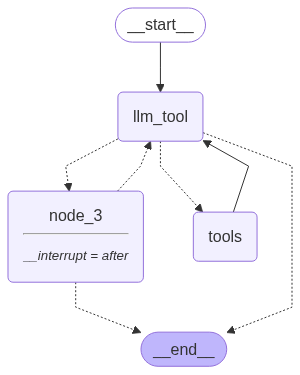

In [26]:
from IPython.display import Image ,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
from langchain_core.messages import SystemMessage,HumanMessage
config = {"configurable":{"thread_id":"test_05"}}

In [28]:
# for event in graph.stream(State(messages= query_prompt_template.invoke({"dialect":db.dialect,"top_k":10,"table_info":db.get_table_info(),"input":input("eneter something:")}).messages+
#     [SystemMessage(content="You are a restaurant management assistant. "
#     "Your role is to help users interact with the restaurant's PostgreSQL database. "
#     "You can perform tasks like checking reservations, adding or updating bookings, managing guests, "
#     "and answering questions using SQL tools. "
#     "Always prefer querying the database to find information. "
#     "If the database does not contain enough information to answer a question, ask the user for more details. "
#     "Do not make assumptions. Always ensure the data is correct before responding. "
#     ),]),config,stream_mode="value"):
#     print(event)
# state=graph.get_state(config)
# print(state.next)
# print(state.values["messages"])
# while(state.next != ()):
#     state=graph.get_state(config)
#     print(state.next)
#     state.values["messages"][-1].pretty_print()
#         # message.pretty_print()
#     graph.update_state(config,State(messages=[HumanMessage(content = input("enter something:"))]))
#     for event in graph.stream(None,config,stream_mode="value"):
#         print(event)
    

In [32]:
for event in graph.stream(State(messages= query_prompt_template.invoke({"dialect":db.dialect,"top_k":10,"table_info":db.get_table_info(),"input":input("eneter something:")}).messages+
    [SystemMessage(content="You are a restaurant management assistant. "
    "Your role is to help users interact with the restaurant's PostgreSQL database. "
    "You can perform tasks like checking reservations, adding or updating bookings, managing guests, "
    "and answering questions using SQL tools. "
    "Always prefer querying the database to find information. "
    "If the database does not contain enough information to answer a question, ask the user for more details. "
    "Do not make assumptions. Always ensure the data is correct before responding. "
    ),]),config,stream_mode="value"):
    print(event)


result='no'


In [33]:
state=graph.get_state(config)
print(state.next)
for message in state.values["messages"]:
    message.pretty_print()


('llm_tool',)
================================ System Message ================================


Given an input question, create a syntactically correct postgresql query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most 10 results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:

CREATE TABLE customers (
	customer_id SERIAL NOT NULL, 
	name TEXT, 
	phone TEXT, 
	email TEXT, 
	CONSTRAINT customers_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customers table:
customer_id	name	phone

In [34]:
while(state.next != ()):
    
        # message.pretty_print()
    graph.update_state(config,State(messages=[HumanMessage(content = input("enter something:"))]))
    for event in graph.stream(None,config,stream_mode="value"):
        print(event)
    state=graph.get_state(config)
    print(state.next)
    state.values["messages"][-1].pretty_print()

result='yes'
()
================================ Human Message =================================

exit


In [18]:
state = graph.get_state(config=config)
state.next

()

In [19]:
for message in state.values["messages"]:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct postgresql query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most 10 results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:

CREATE TABLE customers (
	customer_id SERIAL NOT NULL, 
	name TEXT, 
	phone TEXT, 
	email TEXT, 
	CONSTRAINT customers_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customers table:
customer_id	name	phone	email
1	Alice